# **Desertification Dataset CSV File Structure**

This notebook uses a dataset collected from **Google Earth Engine (GEE)** for five Egyptian governorates: **Dakahlia, Fayoum, Matrouh, New Valley, and North Sinai**.  
The dataset includes **NDVI values**, **geographic coordinates** (longitude & latitude), **soil properties**, and **population data**.  

The goal of this notebook is to **train, tune, and evaluate machine learning models** (Linear Regression, LightGBM, XGBoost, and Ensemble models) to accurately **predict NDVI** based on environmental and demographic features.

All CSV files contain the following columns:

| Column      | Description |
|------------|-------------|
| longitude  | Longitude of the sample point |
| latitude   | Latitude of the sample point |
| year       | Year of the observation |
| month      | Month of the observation |
| area       | Region name |
| ndvi       | Normalized Difference Vegetation Index (NDVI) from MODIS, range -1 to 1 |
| t2m_c      | Temperature at 2 meters (°C) |
| td2m_c     | Dewpoint temperature at 2 meters (°C) |
| rh_pct     | Relative humidity (%) |
| tp_m       | Total precipitation (meters) |
| ssrd_jm2   | Surface solar radiation downward (J/m²) |
| LC_Type1   | Land cover type from WorldCover |
| sand       | Soil sand fraction (%) |
| silt       | Soil silt fraction (%) |
| clay       | Soil clay fraction (%) |
| soc        | Soil organic carbon (%) |
| ph         | Soil pH |
| bdod       | Soil bulk density (g/cm³) |
| cec        | Soil cation exchange capacity (cmol/kg) |
| POP        | Population from WorldPop |


In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
import lightgbm as lgb

In [61]:
file_path = '/content/drive/MyDrive/grad_project_data/des_df.csv'

In [62]:
des_df = pd.read_csv(file_path)

In [63]:
des_df.sample(8)

,longitude,latitude,year,month,area,ndvi,t2m_c,td2m_c,rh_pct,tp_m,ssrd_jm2,LC_Type1,sand,silt,clay,soc,ph,bdod,cec,POP
123875,31.176031,29.298553,2024,7,Fayoum,0.47095,32.672997,14.429622,33.222570,0.000332,1.284420e+10,50,511,215,274,237,78,130,192,150.590100
59127,31.427560,30.125004,2023,11,Dakahlia,0.08780,21.073566,11.828112,55.495460,0.027418,6.211158e+09,50,479,260,261,42,80,139,135,1.150959
49808,31.355696,30.331615,2024,1,Dakahlia,0.62215,15.119398,5.667806,53.201454,0.038838,5.839188e+09,40,423,269,309,323,74,136,182,7.360438
91041,31.481459,30.277718,2024,12,Dakahlia,0.08950,15.453774,6.587425,55.484356,0.014526,5.673575e+09,60,417,252,332,44,80,140,145,4.050118
24558,31.211964,30.277718,2023,1,Dakahlia,0.48930,15.464625,6.341237,54.513687,0.076169,5.706765e+09,40,436,274,291,279,76,135,181,8.723692
492,32.110280,30.726873,2023,2,NorthSinai,0.53700,13.431667,4.931688,56.385063,0.055222,6.237664e+09,40,347,305,348,213,79,135,187,0.338966
14540,32.631300,30.169918,2024,12,NorthSinai,0.10545,14.583473,7.893438,64.168390,0.014841,5.776729e+09,60,397,341,263,64,80,139,153,0.074280
92480,31.427560,30.448397,2025,4,Dakahlia,0.38865,21.043613,8.221231,43.670837,0.012650,1.045190e+10,50,378,257,365,305,74,134,184,81.093310


In [64]:
des_df.shape

(142351, 20)

In [65]:
des_df.columns

Index(['longitude', 'latitude', 'year', 'month', 'area', 'ndvi', 't2m_c',
       'td2m_c', 'rh_pct', 'tp_m', 'ssrd_jm2', 'LC_Type1', 'sand', 'silt',
       'clay', 'soc', 'ph', 'bdod', 'cec', 'POP'],
      dtype='object')

In [66]:
des_df.isnull().sum()

,0
longitude,0
latitude,0
year,0
month,0
area,0
ndvi,0
t2m_c,0
td2m_c,0
rh_pct,0
tp_m,0


In [67]:
des_df.duplicated().sum()

np.int64(21675)

In [68]:
des_df[des_df.duplicated()]

,longitude,latitude,year,month,area,ndvi,t2m_c,td2m_c,rh_pct,tp_m,ssrd_jm2,LC_Type1,sand,silt,clay,soc,ph,bdod,cec,POP
208,32.532490,30.205850,2023,2,NorthSinai,0.36810,13.551106,5.547193,58.394780,0.009502,6.614239e+09,60,385,324,291,164,80,130,153,0.000004
339,32.514523,30.044155,2023,2,NorthSinai,0.30410,13.447975,5.377669,58.100660,0.032307,6.700630e+09,60,439,263,299,70,80,137,151,0.212417
358,32.415707,31.068233,2023,2,NorthSinai,0.06285,14.173770,6.287822,59.027504,0.105408,6.278621e+09,60,341,348,312,202,80,143,195,0.000071
401,34.230305,31.265863,2023,2,NorthSinai,0.41910,13.476676,6.754238,63.777702,0.337995,6.172086e+09,20,449,314,238,211,79,149,218,6.424750
403,32.433674,30.502295,2023,2,NorthSinai,0.14775,13.109697,4.937879,57.607197,0.037717,6.464834e+09,60,375,306,320,62,80,139,166,0.089334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142306,27.861248,31.050268,2023,10,Matrouh,0.11110,23.390780,17.192825,68.161896,0.086181,7.603587e+09,60,345,356,299,145,80,144,167,0.006643
142324,27.771418,31.140099,2023,10,Matrouh,0.09810,22.908484,16.738565,68.187515,0.083316,7.651712e+09,60,386,334,281,151,79,149,150,0.155268
142326,27.582771,31.050268,2023,10,Matrouh,0.12140,22.489164,16.237993,67.752300,0.076293,7.672820e+09,60,346,373,281,138,80,143,162,0.000018
142333,27.807350,31.167050,2023,10,Matrouh,0.12230,23.363857,17.294537,68.713720,0.095085,7.544428e+09,60,362,348,290,161,79,146,172,0.281923


In [69]:
des_df = des_df.drop_duplicates()

In [70]:
# Total rows after removing duplicates
len(des_df)

120676

In [71]:
# Checking that data hasn't duplicates anymore!
total_rows = len(des_df)
duplicate_rows = des_df.duplicated().sum()
unique_rows = len(des_df.drop_duplicates())

duplicate_percentage = (duplicate_rows / total_rows) * 100
unique_percentage = (unique_rows / total_rows) * 100

print(f"Total rows: {total_rows}")
print(f"Duplicate rows: {duplicate_rows} ({duplicate_percentage:.2f}%)")
print(f"Unique rows: {unique_rows} ({unique_percentage:.2f}%)")

Total rows: 120676
Duplicate rows: 0 (0.00%)
Unique rows: 120676 (100.00%)


In [72]:
des_df.dtypes

,0
longitude,float64
latitude,float64
year,int64
month,int64
area,object
ndvi,float64
t2m_c,float64
td2m_c,float64
rh_pct,float64
tp_m,float64


> Majority features numeric, just one feature that is categorical: 'area' that reresent the governorate

# **Discovering Correlation**

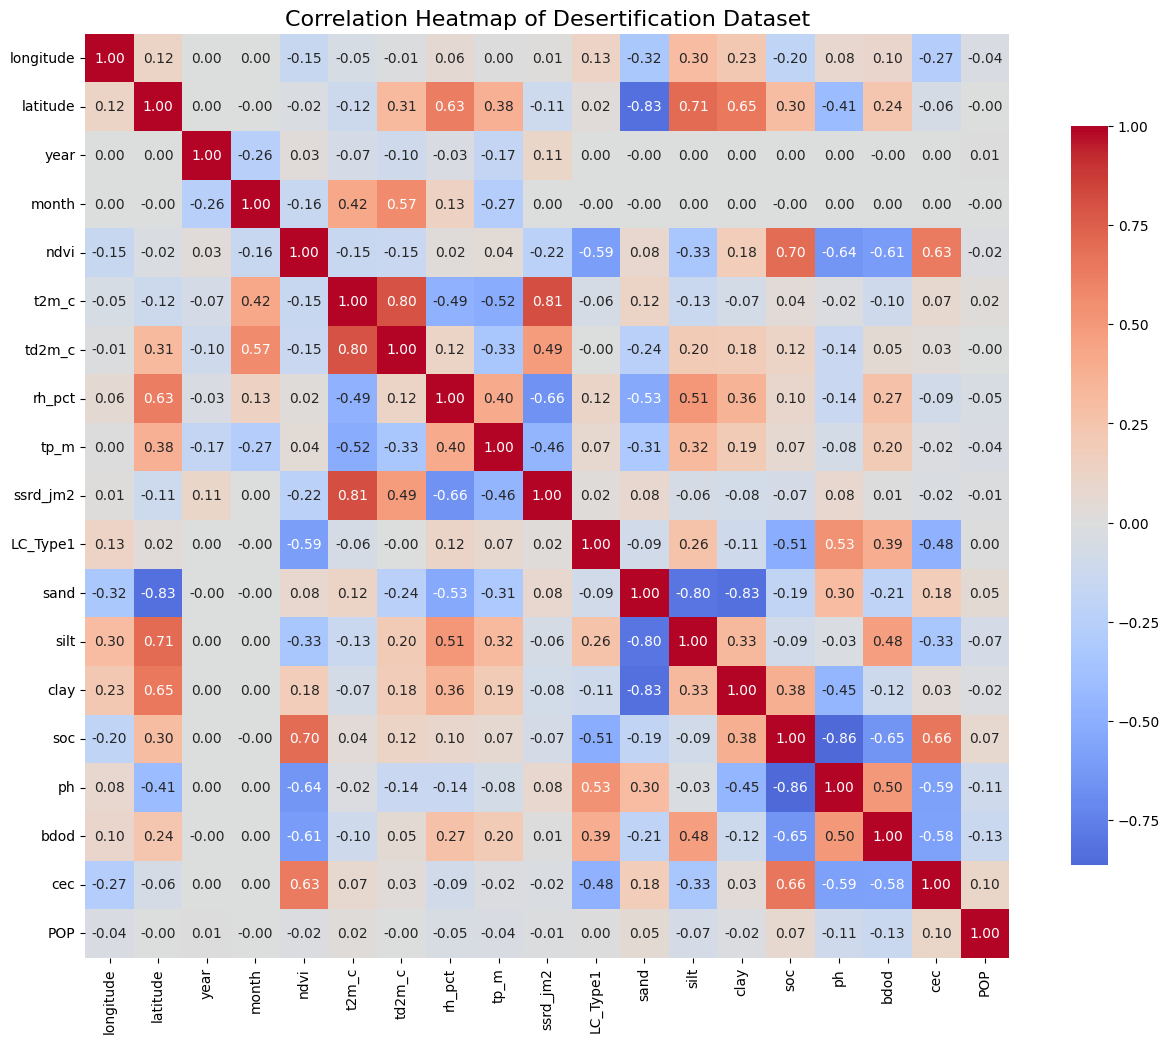

/tmp/ipython-input-3480176760.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette=colors)


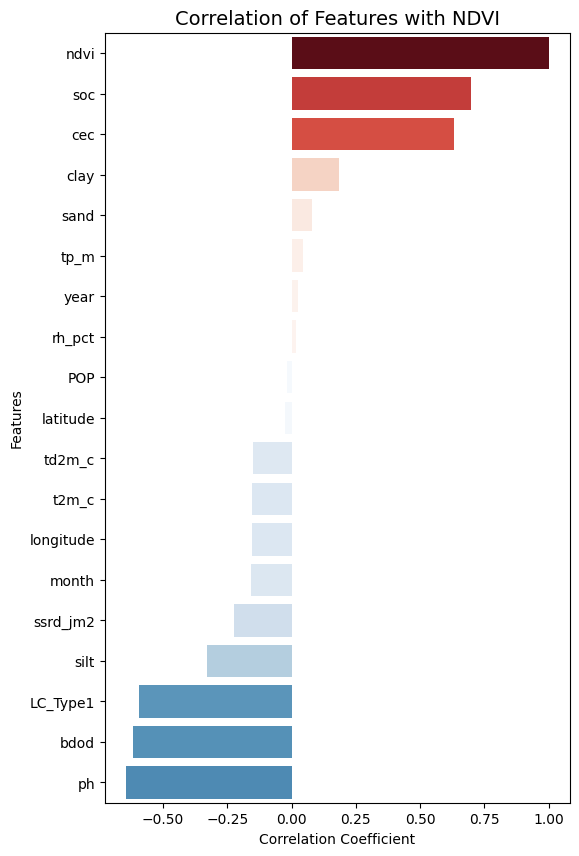

In [73]:
# Explore the features correlations with Correlation Heatmap
numeric_df = des_df.drop(columns=['area'])
corr = numeric_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            center=0,
            square=True,
            cbar_kws={"shrink": 0.8})
plt.title("Correlation Heatmap of Desertification Dataset", fontsize=16)
plt.show()

# Target-focused correlation: NDVI
target_corr = corr['ndvi'].sort_values(ascending=False)
colors = [plt.cm.Reds(val) if val > 0 else plt.cm.Blues(-val) for val in target_corr.values]

plt.figure(figsize=(6, 10))
sns.barplot(x=target_corr.values, y=target_corr.index, palette=colors)
plt.title("Correlation of Features with NDVI", fontsize=14)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.show()

In [74]:
# Extract & display the correlation values for NDVI in a sorted table.
corr = numeric_df.corr()
ndvi_corr = corr['ndvi'].sort_values(ascending=False)

ndvi_corr_df = pd.DataFrame(ndvi_corr).reset_index() # Make it into a dataframe
ndvi_corr_df.columns = ['Feature', 'Correlation with NDVI']

print(ndvi_corr_df)

      Feature  Correlation with NDVI
0        ndvi               1.000000
1         soc               0.696681
2         cec               0.631559
3        clay               0.183402
4        sand               0.081310
5        tp_m               0.044576
6        year               0.026213
7      rh_pct               0.018458
8         POP              -0.018745
9    latitude              -0.024211
10     td2m_c              -0.148382
11      t2m_c              -0.152734
12  longitude              -0.154124
13      month              -0.157859
14   ssrd_jm2              -0.223918
15       silt              -0.329724
16   LC_Type1              -0.594109
17       bdod              -0.614996
18         ph              -0.644046


1. Soil quality drives vegetation: SOC, CEC, clay content positively influence NDVI.

2. Soil limitations reduce vegetation: High pH, bulk density, certain land cover types, and high silt content negatively impact NDVI.

3. Climate & geography effects are mild: Temperature, sunshine, and location show weak negative correlations.

# **Feature Engineering**

In [75]:
# Create season from month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

des_df['season'] = des_df['month'].apply(get_season)

Soil feature engineering - calc the ratio of sand & clay & silt

1. High sand content (sand_ratio ↑):

- Soil drains quickly, losing water and nutrients.

- NDVI is often lower.

2. High clay content (clay_ratio ↑):

- Retains water but may cause drainage problems (waterlogging).

- Impact on NDVI depends on the crop.

3. High silt content (silt_ratio ↑):

- Balances sand and clay for an ideal growth environment.

- NDVI tends to be higher.

> Direct link to soil fertility:
The balance of sand, silt, and clay affects root access to water and nutrients.
This relationship is reflected in NDVI.

In [76]:
des_df['soil_total'] = des_df['sand'] + des_df['silt'] + des_df['clay']

des_df['sand_ratio'] = des_df['sand'] / des_df['soil_total']
des_df['silt_ratio'] = des_df['silt'] / des_df['soil_total']
des_df['clay_ratio'] = des_df['clay'] / des_df['soil_total']

des_df = des_df.drop(columns=['soil_total'])

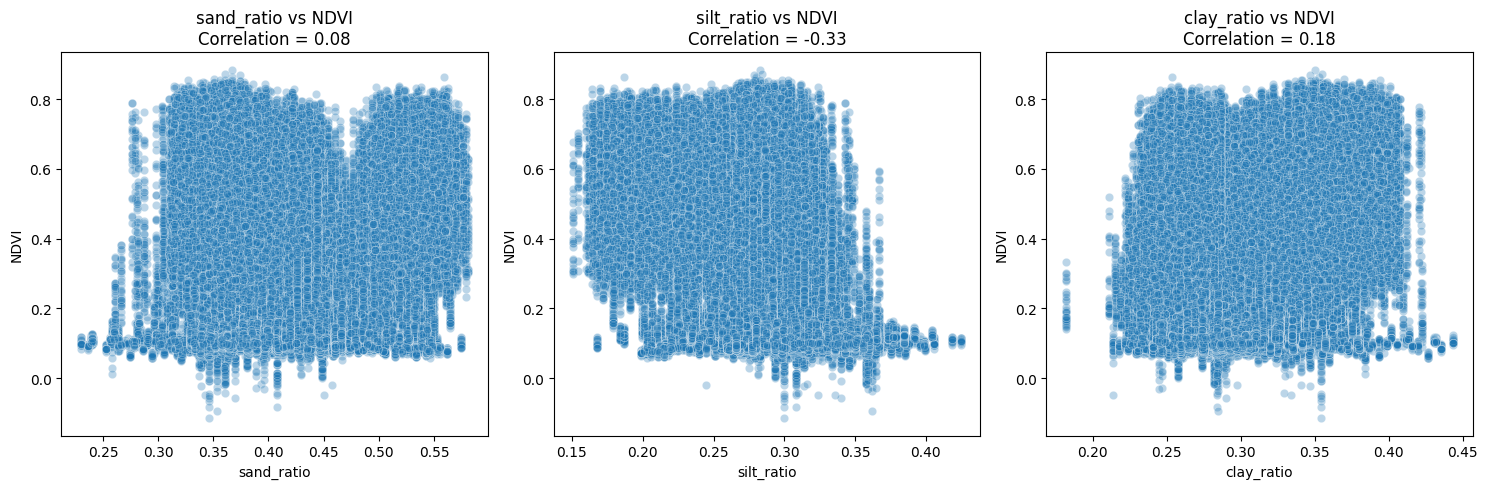

In [77]:
# Scatter plots to visualize relation with NDVI
ratios = ['sand_ratio', 'silt_ratio', 'clay_ratio']

plt.figure(figsize=(15, 5))
for i, ratio in enumerate(ratios, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=des_df[ratio], y=des_df['ndvi'], alpha=0.3)
    corr = des_df[ratio].corr(des_df['ndvi'])
    plt.title(f"{ratio} vs NDVI\nCorrelation = {corr:.2f}")
    plt.xlabel(ratio)
    plt.ylabel("NDVI")
plt.tight_layout()
plt.show()

1. Sand Ratio (Correlation = 0.08)

- Very weak positive correlation.

- Suggests that sand proportion in soil has almost no effect on vegetation health (NDVI).

2. Silt Ratio (Correlation = -0.33)

- Moderate negative correlation.

- Higher silt content tends to reduce NDVI, meaning soils with more silt may support less vegetation growth.

3. Clay Ratio (Correlation = 0.18)

- Weak positive correlation.

- Indicates clay contributes slightly to vegetation health, possibly by improving water retention.

In [78]:
# Combine effect of soil organic matter and nutrient-holding capacity (soc & cec)
des_df['soc_cec'] = des_df['soc'] * des_df['cec']

In [79]:
des_df.columns

Index(['longitude', 'latitude', 'year', 'month', 'area', 'ndvi', 't2m_c',
       'td2m_c', 'rh_pct', 'tp_m', 'ssrd_jm2', 'LC_Type1', 'sand', 'silt',
       'clay', 'soc', 'ph', 'bdod', 'cec', 'POP', 'season', 'sand_ratio',
       'silt_ratio', 'clay_ratio', 'soc_cec'],
      dtype='object')

**Feature Importance**

In [80]:
from sklearn.ensemble import RandomForestRegressor

In [81]:
X = des_df.drop(columns=['ndvi'])
y = des_df['ndvi']

In [82]:
des_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120676 entries, 0 to 142350
Data columns (total 25 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   longitude   120676 non-null  float64
 1   latitude    120676 non-null  float64
 2   year        120676 non-null  int64  
 3   month       120676 non-null  int64  
 4   area        120676 non-null  object 
 5   ndvi        120676 non-null  float64
 6   t2m_c       120676 non-null  float64
 7   td2m_c      120676 non-null  float64
 8   rh_pct      120676 non-null  float64
 9   tp_m        120676 non-null  float64
 10  ssrd_jm2    120676 non-null  float64
 11  LC_Type1    120676 non-null  int64  
 12  sand        120676 non-null  int64  
 13  silt        120676 non-null  int64  
 14  clay        120676 non-null  int64  
 15  soc         120676 non-null  int64  
 16  ph          120676 non-null  int64  
 17  bdod        120676 non-null  int64  
 18  cec         120676 non-null  int64  
 19  POP    

In [83]:
# OneHotEncoder for categorical features
categorical_features = ['season', 'area']
numeric_features = [col for col in X.columns if col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

In [84]:
# Transform features
X = preprocessor.fit_transform(X)

In [85]:
# LightGBM Dataset
train_data = lgb.Dataset(X, label=y)

In [86]:
params = {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt'}
model = lgb.train(params, train_data, num_boost_round=200)

In [87]:
# Feature importance
importance = model.feature_importance()
feat_importance = pd.Series(importance, index=preprocessor.get_feature_names_out()).sort_values(ascending=False)

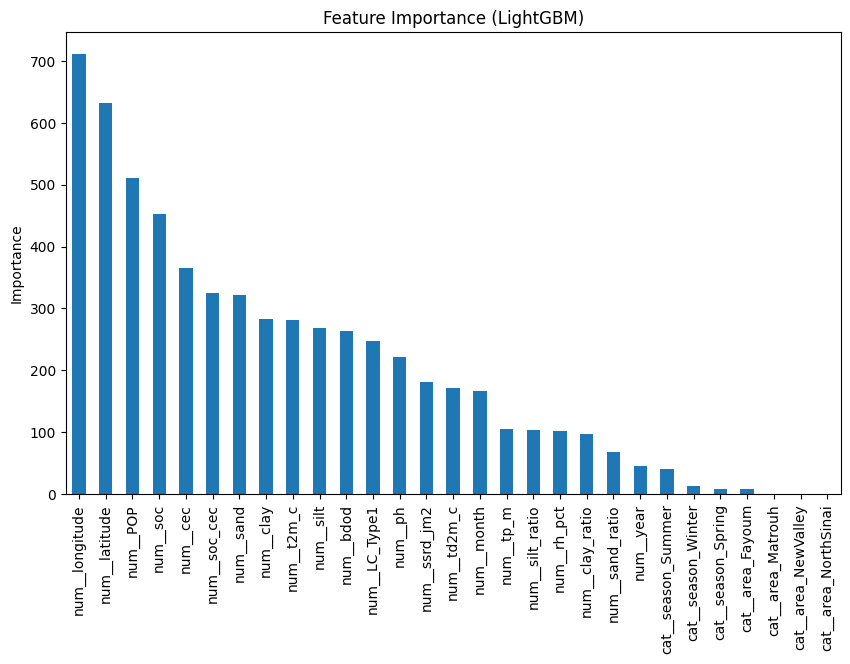

In [88]:
# Plotting Feature importance
plt.figure(figsize=(10,6))
feat_importance.plot(kind='bar')
plt.title("Feature Importance (LightGBM)")
plt.ylabel("Importance")
plt.show()

In [89]:
# Convert to DataFrame for a clean table
feat_importance_df = pd.DataFrame({
    'Feature': feat_importance.index,
    'Importance': feat_importance.values
}).reset_index(drop=True)

# Sort descending
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

In [90]:
# Add percentage column
feat_importance_df['Percent'] = 100 * feat_importance_df['Importance'] / feat_importance_df['Importance'].sum()

# Sort descending
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Display top 20
print("Top 20 Features by Importance:")
print(feat_importance_df.head(20))

low_importance = feat_importance_df[feat_importance_df['Percent'] < 2]

print("\nFeatures suggested to drop (less than 2% importance):")
print(low_importance)

Top 20 Features by Importance:
            Feature  Importance    Percent
0    num__longitude         711  11.850000
1     num__latitude         632  10.533333
2          num__POP         511   8.516667
3          num__soc         452   7.533333
4          num__cec         366   6.100000
5      num__soc_cec         325   5.416667
6         num__sand         322   5.366667
7         num__clay         283   4.716667
8        num__t2m_c         282   4.700000
9         num__silt         269   4.483333
10        num__bdod         263   4.383333
11    num__LC_Type1         247   4.116667
12          num__ph         222   3.700000
13    num__ssrd_jm2         182   3.033333
14      num__td2m_c         171   2.850000
15       num__month         166   2.766667
16        num__tp_m         106   1.766667
17  num__silt_ratio         104   1.733333
18      num__rh_pct         102   1.700000
19  num__clay_ratio          98   1.633333

Features suggested to drop (less than 2% importance):
           

In [91]:
# List of features to drop based on low importance
cols_to_drop_post_process = [
    'num__tp_m',
    'num__silt_ratio',
    'num__rh_pct',
    'num__clay_ratio',
    'num__sand_ratio',
    'num__year',
    'cat__season_Summer',
    'cat__season_Winter',
    'cat__season_Spring',
    'cat__area_Fayoum',
    'cat__area_Matrouh',
    'cat__area_NewValley',
    'cat__area_NorthSinai'
]

preprocessed_feature_names = preprocessor.get_feature_names_out()

indices_to_drop = [
    i for i, feature in enumerate(preprocessed_feature_names)
    if feature in cols_to_drop_post_process
]

X = X[:, [i for i in range(X.shape[1]) if i not in indices_to_drop]]

# **Modeling**

In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [93]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**1. Linear Regression**

In [94]:
# Linear Regression
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [95]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [96]:
y_pred_lr = lr.predict(X_test)

In [97]:
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

In [98]:
print("Linear Regression Results")
print(f"RMSE: {rmse_lr:.4f}, MSE: {mse_lr:.4f}, R²: {r2_lr:.4f}")

Linear Regression Results
RMSE: 0.1115, MSE: 0.0124, R²: 0.7179


**2. LightGBM Model**

In [99]:
# LightGBM Model
X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [100]:
train_data = lgb.Dataset(X_train_lgb, label=y_train_lgb)
valid_data = lgb.Dataset(X_test_lgb, label=y_test_lgb)

In [101]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1
}

In [102]:
model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
    num_boost_round=500,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.043696


In [103]:
y_pred_lgb = model.predict(X_test_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test_lgb, y_pred_lgb))
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test_lgb, y_pred_lgb)

In [104]:
print("\nLightGBM Results")
print(f"RMSE: {rmse_lgb:.4f}, MSE: {mse_lgb:.4f}, R²: {r2_lgb:.4f}")


LightGBM Results
RMSE: 0.0437, MSE: 0.0019, R²: 0.9567


**3. XGBoost Regressor**

In [105]:
# XGBoost Regressor
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [106]:
import xgboost as xgb

In [107]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [108]:
params = {'objective': 'reg:squarederror', 'eta': 0.05, 'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.8, 'seed': 42, 'eval_metric': 'rmse'}
evals = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=500, evals=evals, early_stopping_rounds=50, verbose_eval=50)

[0]	train-rmse:0.20148	eval-rmse:0.20116
[50]	train-rmse:0.06906	eval-rmse:0.06923
[100]	train-rmse:0.05970	eval-rmse:0.06052
[150]	train-rmse:0.05635	eval-rmse:0.05753
[200]	train-rmse:0.05369	eval-rmse:0.05512
[250]	train-rmse:0.05169	eval-rmse:0.05330
[300]	train-rmse:0.04991	eval-rmse:0.05177
[350]	train-rmse:0.04817	eval-rmse:0.05028
[400]	train-rmse:0.04690	eval-rmse:0.04919
[450]	train-rmse:0.04561	eval-rmse:0.04811
[499]	train-rmse:0.04455	eval-rmse:0.04724


In [109]:
y_pred_xgb = model.predict(dtest)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

In [110]:
y_pred = model.predict(dtest)

In [111]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred)

In [112]:
print("XGBoost Results")
print(f"RMSE: {rmse_xgb:.4f}, MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}")

XGBoost Results
RMSE: 0.0472, MSE: 0.0022, R²: 0.9494


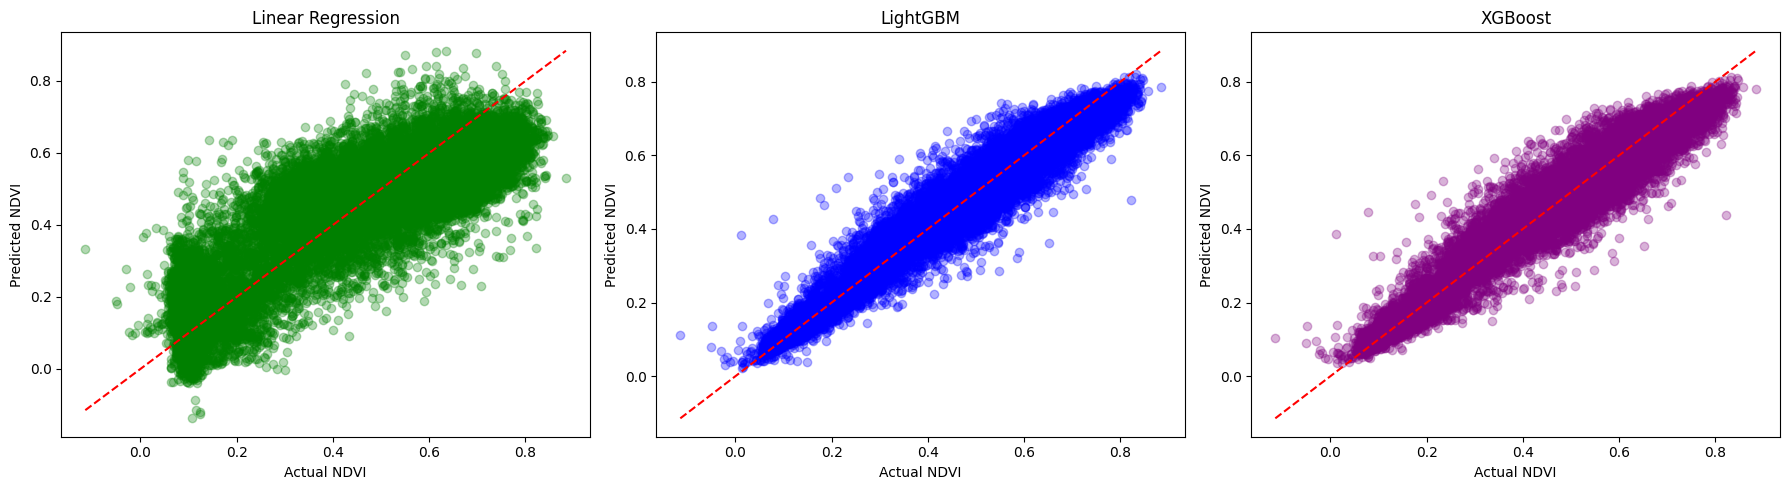

In [113]:
# Scatterplot for the 3 models
plt.figure(figsize=(18,5))

# Linear Regression
plt.subplot(1,3,1)
plt.scatter(y_test, y_pred_lr, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual NDVI")
plt.ylabel("Predicted NDVI")
plt.title("Linear Regression")

# LightGBM
plt.subplot(1,3,2)
plt.scatter(y_test_lgb, y_pred_lgb, alpha=0.3, color='blue')
plt.plot([y_test_lgb.min(), y_test_lgb.max()], [y_test_lgb.min(), y_test_lgb.max()], 'r--')
plt.xlabel("Actual NDVI")
plt.ylabel("Predicted NDVI")
plt.title("LightGBM")

# XGBoost
plt.subplot(1,3,3)
plt.scatter(y_test, y_pred, alpha=0.3, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual NDVI")
plt.ylabel("Predicted NDVI")
plt.title("XGBoost")

plt.tight_layout()
plt.show()

**Ensemble Models: Simple Averaging, Stack**

**4. Simple Averaging Ensemble**

In [114]:
# Simple Averaging Ensemble
y_pred_avg = (y_pred_lgb + y_pred + y_pred_lr) / 3

In [115]:
rmse_avg = np.sqrt(mean_squared_error(y_test, y_pred_avg))
mse_avg = mean_squared_error(y_test, y_pred_avg)
r2_avg = r2_score(y_test, y_pred_avg)

In [116]:
print("Averaging Ensemble")
print(f"RMSE: {rmse_avg:.4f}, MSE: {mse_avg:.4f}, R²: {r2_avg:.4f}")

Averaging Ensemble
RMSE: 0.0588, MSE: 0.0035, R²: 0.9217


**5. Stacking Regressor: Linear Regression + LightGBM Regressor + XGBoost Regressor**

In [117]:
estimators = [
    ('lr', LinearRegression()),
    ('lgb', lgb.LGBMRegressor(objective='regression', n_estimators=300, learning_rate=0.05, random_state=42)),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42))
]

In [118]:
from sklearn.ensemble import StackingRegressor

In [119]:
stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    n_jobs=-1
)
stack_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(), n_jobs=-1)

In [120]:
stack_model.fit(X_train, y_train)
y_pred_stack = stack_model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [121]:
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
mse_stack = mean_squared_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

In [122]:
print("Stacking Ensemble")
print(f"RMSE: {rmse_stack:.4f}, MSE: {mse_stack:.4f}, R²: {r2_stack:.4f}")

Stacking Ensemble
RMSE: 0.0513, MSE: 0.0026, R²: 0.9403


**Compare Models**

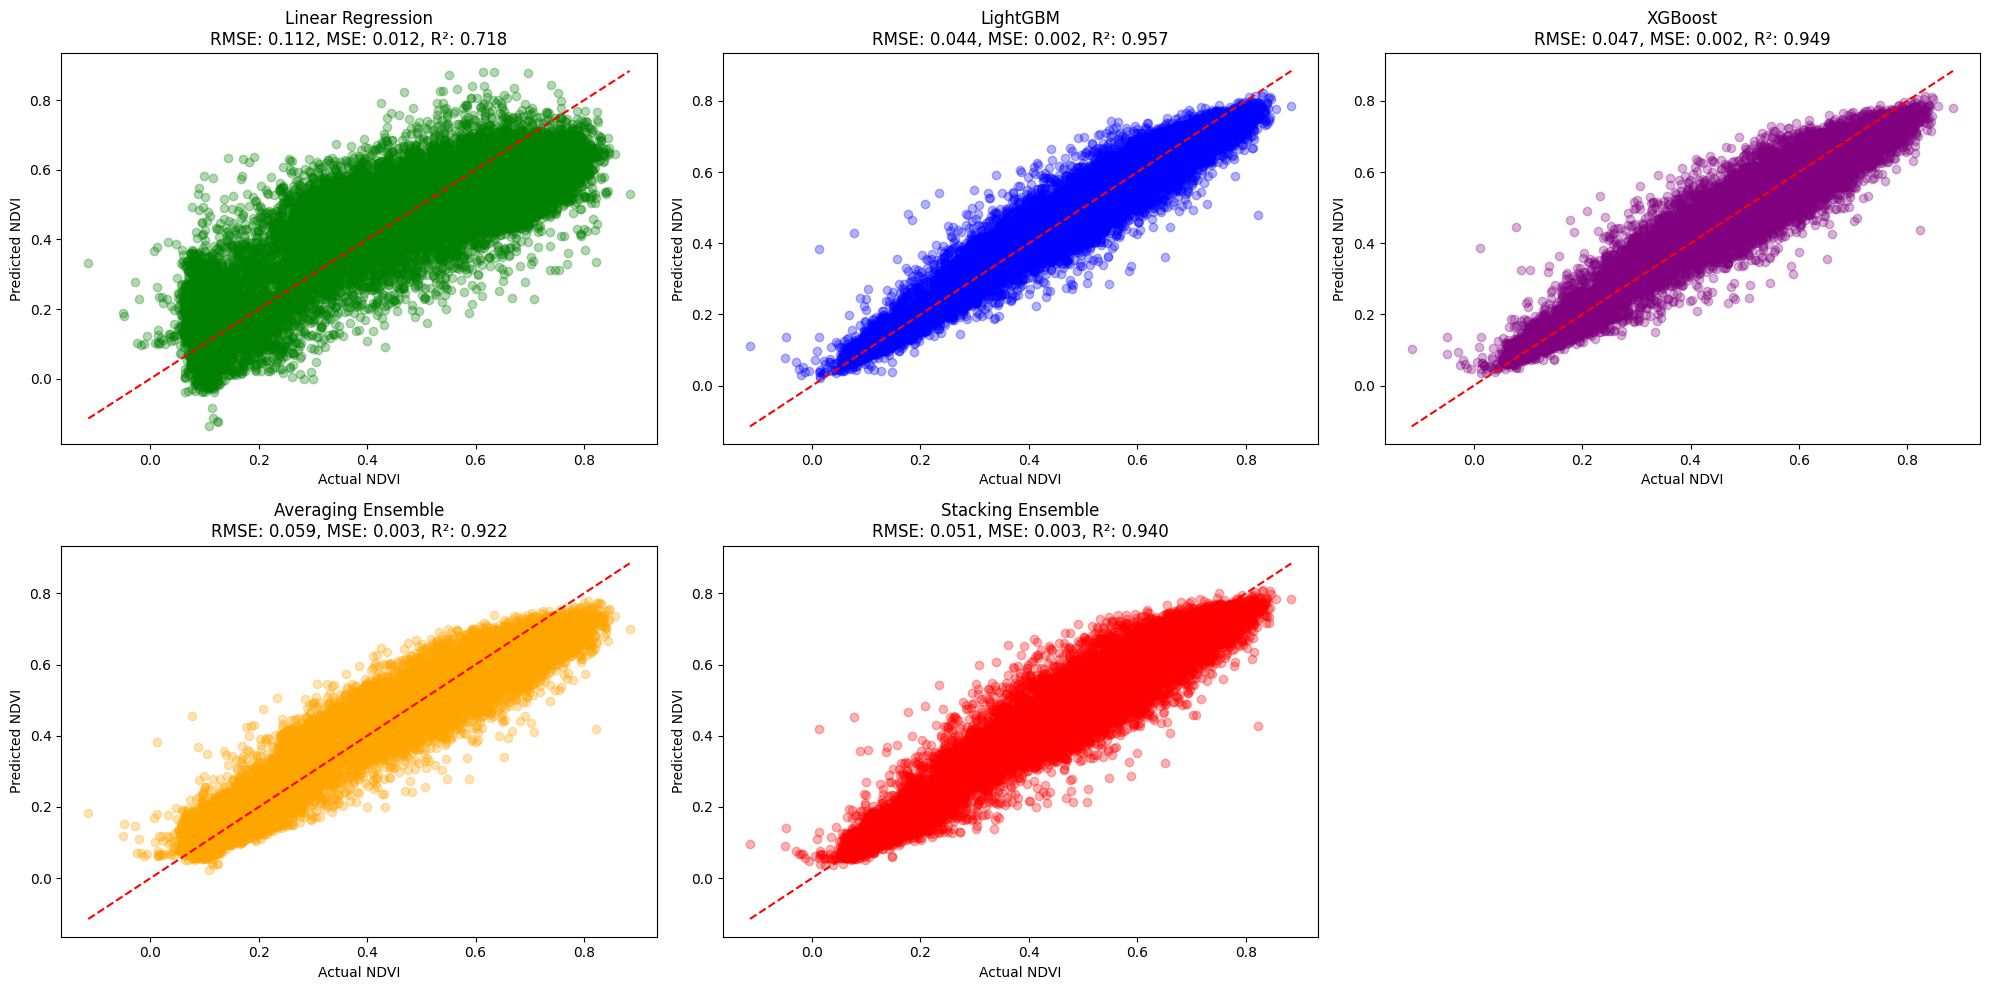

In [123]:
# Scatterplot for the 5 models
plt.figure(figsize=(20,10))

# Linear Regression
plt.subplot(2,3,1)
plt.scatter(y_test, y_pred_lr, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual NDVI")
plt.ylabel("Predicted NDVI")
plt.title(f"Linear Regression\nRMSE: {rmse_lr:.3f}, MSE: {mse_lr:.3f}, R²: {r2_lr:.3f}")

# LightGBM
plt.subplot(2,3,2)
plt.scatter(y_test, y_pred_lgb, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual NDVI")
plt.ylabel("Predicted NDVI")
plt.title(f"LightGBM\nRMSE: {rmse_lgb:.3f}, MSE: {mse_lgb:.3f}, R²: {r2_lgb:.3f}")

# XGBoost
plt.subplot(2,3,3)
plt.scatter(y_test, y_pred_xgb, alpha=0.3, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual NDVI")
plt.ylabel("Predicted NDVI")
plt.title(f"XGBoost\nRMSE: {rmse_xgb:.3f}, MSE: {mse_xgb:.3f}, R²: {r2_xgb:.3f}")

# Averaging Ensemble
plt.subplot(2,3,4)
plt.scatter(y_test, y_pred_avg, alpha=0.3, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual NDVI")
plt.ylabel("Predicted NDVI")
plt.title(f"Averaging Ensemble\nRMSE: {rmse_avg:.3f}, MSE: {mse_avg:.3f}, R²: {r2_avg:.3f}")

# Stacking Ensemble
plt.subplot(2,3,5)
plt.scatter(y_test, y_pred_stack, alpha=0.3, color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual NDVI")
plt.ylabel("Predicted NDVI")
plt.title(f"Stacking Ensemble\nRMSE: {rmse_stack:.3f}, MSE: {mse_stack:.3f}, R²: {r2_stack:.3f}")

plt.tight_layout()
plt.show()

**6. Hyperparameter Tuning with Optuna on LightGBM**

In [124]:
# Hyperparameter Tuning with Optuna on LightGBM
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [125]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 6.1 MB/s eta 0:00:00


In [126]:
# Optuna objective function
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "verbosity": -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)

    model = lgb.train(
        params,
        train_data,
        valid_sets=[valid_data],
        num_boost_round=500,
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
    )

    preds = model.predict(X_valid)
    mse = mean_squared_error(y_valid, preds)
    return mse

In [127]:
# Run Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-09-05 18:11:26,124] A new study created in memory with name: no-name-5b1c23a5-096a-44f0-99e1-f35e9e569064


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0371639


[I 2025-09-05 18:12:15,392] Trial 0 finished with value: 0.0013811521821009685 and parameters: {'learning_rate': 0.028968994315540467, 'num_leaves': 1361, 'max_depth': 11, 'min_child_samples': 12, 'feature_fraction': 0.6901604209225857, 'bagging_fraction': 0.4847105941859328, 'bagging_freq': 2, 'lambda_l1': 0.08801865078555779, 'lambda_l2': 1.1014457476662997e-08}. Best is trial 0 with value: 0.0013811521821009685.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0499403


[I 2025-09-05 18:12:39,063] Trial 1 finished with value: 0.002494036655030268 and parameters: {'learning_rate': 0.010414856579734224, 'num_leaves': 2846, 'max_depth': 9, 'min_child_samples': 35, 'feature_fraction': 0.9197562348881098, 'bagging_fraction': 0.8688312096876302, 'bagging_freq': 8, 'lambda_l1': 0.1575371725297077, 'lambda_l2': 7.784865575560523e-08}. Best is trial 0 with value: 0.0013811521821009685.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0441296


[I 2025-09-05 18:12:50,089] Trial 2 finished with value: 0.0019474224994804996 and parameters: {'learning_rate': 0.053929606823742274, 'num_leaves': 1810, 'max_depth': 7, 'min_child_samples': 40, 'feature_fraction': 0.53605029202034, 'bagging_fraction': 0.7211955379078292, 'bagging_freq': 9, 'lambda_l1': 2.928640937766051e-05, 'lambda_l2': 2.8007062818834615e-08}. Best is trial 0 with value: 0.0013811521821009685.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's rmse: 0.037624


[I 2025-09-05 18:13:09,437] Trial 3 finished with value: 0.0014155645921967157 and parameters: {'learning_rate': 0.28918929346173644, 'num_leaves': 2753, 'max_depth': 14, 'min_child_samples': 66, 'feature_fraction': 0.4990454028855621, 'bagging_fraction': 0.4201865364762679, 'bagging_freq': 4, 'lambda_l1': 3.4536593045320166e-08, 'lambda_l2': 1.9455459141159164e-08}. Best is trial 0 with value: 0.0013811521821009685.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0574859


[I 2025-09-05 18:13:15,571] Trial 4 finished with value: 0.0033046325427396124 and parameters: {'learning_rate': 0.2346686487541164, 'num_leaves': 2789, 'max_depth': 3, 'min_child_samples': 91, 'feature_fraction': 0.5941898817611798, 'bagging_fraction': 0.4153963990431114, 'bagging_freq': 8, 'lambda_l1': 5.628739813582267e-08, 'lambda_l2': 1.3415070315405922e-08}. Best is trial 0 with value: 0.0013811521821009685.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.051363


[I 2025-09-05 18:13:25,852] Trial 5 finished with value: 0.0026381577483290176 and parameters: {'learning_rate': 0.017225368635175566, 'num_leaves': 1280, 'max_depth': 8, 'min_child_samples': 75, 'feature_fraction': 0.4691743888034353, 'bagging_fraction': 0.5284936535699107, 'bagging_freq': 10, 'lambda_l1': 1.648046985007671e-07, 'lambda_l2': 0.022309549734634282}. Best is trial 0 with value: 0.0013811521821009685.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0514967


[I 2025-09-05 18:13:36,955] Trial 6 finished with value: 0.002651911844729955 and parameters: {'learning_rate': 0.05458598378414499, 'num_leaves': 2584, 'max_depth': 6, 'min_child_samples': 18, 'feature_fraction': 0.986648012958372, 'bagging_fraction': 0.610953631182745, 'bagging_freq': 5, 'lambda_l1': 4.116665365188688, 'lambda_l2': 0.29283799089103885}. Best is trial 0 with value: 0.0013811521821009685.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0442619


[I 2025-09-05 18:13:44,157] Trial 7 finished with value: 0.00195911780539838 and parameters: {'learning_rate': 0.21996279364048027, 'num_leaves': 863, 'max_depth': 5, 'min_child_samples': 40, 'feature_fraction': 0.6166220819651911, 'bagging_fraction': 0.42952114815366876, 'bagging_freq': 5, 'lambda_l1': 0.004386858106201324, 'lambda_l2': 4.458475397167262e-05}. Best is trial 0 with value: 0.0013811521821009685.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0493003


[I 2025-09-05 18:13:58,449] Trial 8 finished with value: 0.002430519549868706 and parameters: {'learning_rate': 0.02585895892673708, 'num_leaves': 1144, 'max_depth': 8, 'min_child_samples': 70, 'feature_fraction': 0.74489021427004, 'bagging_fraction': 0.933786944477085, 'bagging_freq': 10, 'lambda_l1': 2.851501673788546, 'lambda_l2': 0.08316306000205918}. Best is trial 0 with value: 0.0013811521821009685.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0391886


[I 2025-09-05 18:14:21,878] Trial 9 finished with value: 0.0015357475489098905 and parameters: {'learning_rate': 0.021898985091598194, 'num_leaves': 483, 'max_depth': 12, 'min_child_samples': 52, 'feature_fraction': 0.664383306788463, 'bagging_fraction': 0.9949028199230637, 'bagging_freq': 9, 'lambda_l1': 1.2747717679168627e-05, 'lambda_l2': 1.2663863276252417e-06}. Best is trial 0 with value: 0.0013811521821009685.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[453]	valid_0's rmse: 0.0344096


[I 2025-09-05 18:14:52,415] Trial 10 finished with value: 0.0011840189223069912 and parameters: {'learning_rate': 0.12297510521078972, 'num_leaves': 1931, 'max_depth': 12, 'min_child_samples': 10, 'feature_fraction': 0.8085040560713053, 'bagging_fraction': 0.7380454734138292, 'bagging_freq': 1, 'lambda_l1': 0.00923431124043157, 'lambda_l2': 0.00040728637439348874}. Best is trial 10 with value: 0.0011840189223069912.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0342324


[I 2025-09-05 18:15:25,593] Trial 11 finished with value: 0.0011718576581886836 and parameters: {'learning_rate': 0.11117167712380786, 'num_leaves': 1735, 'max_depth': 12, 'min_child_samples': 8, 'feature_fraction': 0.7869908313164806, 'bagging_fraction': 0.7608380626930296, 'bagging_freq': 1, 'lambda_l1': 0.008428433149600977, 'lambda_l2': 0.00033901707753851705}. Best is trial 11 with value: 0.0011718576581886836.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[320]	valid_0's rmse: 0.035179


[I 2025-09-05 18:16:09,423] Trial 12 finished with value: 0.0012375650685928434 and parameters: {'learning_rate': 0.11829263159873574, 'num_leaves': 2015, 'max_depth': 15, 'min_child_samples': 5, 'feature_fraction': 0.8148686408375275, 'bagging_fraction': 0.7704965415558167, 'bagging_freq': 1, 'lambda_l1': 0.0012380317603112954, 'lambda_l2': 0.0008583995608713481}. Best is trial 11 with value: 0.0011718576581886836.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[498]	valid_0's rmse: 0.0339498


[I 2025-09-05 18:16:39,463] Trial 13 finished with value: 0.001152587995687954 and parameters: {'learning_rate': 0.10718100213940489, 'num_leaves': 2106, 'max_depth': 12, 'min_child_samples': 19, 'feature_fraction': 0.8224469369951404, 'bagging_fraction': 0.7842066306784983, 'bagging_freq': 3, 'lambda_l1': 0.03895100420820828, 'lambda_l2': 9.63918028709984}. Best is trial 13 with value: 0.001152587995687954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0346509


[I 2025-09-05 18:17:03,361] Trial 14 finished with value: 0.0012006878649976366 and parameters: {'learning_rate': 0.1104094363119253, 'num_leaves': 2353, 'max_depth': 11, 'min_child_samples': 27, 'feature_fraction': 0.8620604139353165, 'bagging_fraction': 0.8428581599564935, 'bagging_freq': 3, 'lambda_l1': 0.00011027232323779529, 'lambda_l2': 9.345221972857852}. Best is trial 13 with value: 0.001152587995687954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's rmse: 0.0341412


[I 2025-09-05 18:17:32,526] Trial 15 finished with value: 0.0011656241286928336 and parameters: {'learning_rate': 0.08060354440880538, 'num_leaves': 1696, 'max_depth': 13, 'min_child_samples': 25, 'feature_fraction': 0.7710361115485975, 'bagging_fraction': 0.6222290679592509, 'bagging_freq': 3, 'lambda_l1': 0.07523298581049548, 'lambda_l2': 9.61570244977592e-06}. Best is trial 13 with value: 0.001152587995687954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0345369


[I 2025-09-05 18:18:05,598] Trial 16 finished with value: 0.0011927955919369532 and parameters: {'learning_rate': 0.07371846100837083, 'num_leaves': 2293, 'max_depth': 14, 'min_child_samples': 24, 'feature_fraction': 0.8911620019189616, 'bagging_fraction': 0.6389941926363654, 'bagging_freq': 6, 'lambda_l1': 0.3055042425062708, 'lambda_l2': 4.40649750417443e-06}. Best is trial 13 with value: 0.001152587995687954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0348442


[I 2025-09-05 18:18:30,342] Trial 17 finished with value: 0.0012141161109591949 and parameters: {'learning_rate': 0.07625861678394254, 'num_leaves': 794, 'max_depth': 14, 'min_child_samples': 47, 'feature_fraction': 0.737574573680719, 'bagging_fraction': 0.6382472631459893, 'bagging_freq': 3, 'lambda_l1': 3.001511646838958e-06, 'lambda_l2': 7.9596125279330305}. Best is trial 13 with value: 0.001152587995687954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0385085


[I 2025-09-05 18:18:49,635] Trial 18 finished with value: 0.0014829012489198368 and parameters: {'learning_rate': 0.03887498560066183, 'num_leaves': 2219, 'max_depth': 10, 'min_child_samples': 28, 'feature_fraction': 0.981146625115645, 'bagging_fraction': 0.574799331714888, 'bagging_freq': 3, 'lambda_l1': 0.047789350775536546, 'lambda_l2': 0.00816252900530892}. Best is trial 13 with value: 0.001152587995687954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0376406


[I 2025-09-05 18:19:00,620] Trial 19 finished with value: 0.0014168143713580274 and parameters: {'learning_rate': 0.16800089077536154, 'num_leaves': 61, 'max_depth': 13, 'min_child_samples': 62, 'feature_fraction': 0.8464025706544238, 'bagging_fraction': 0.8149568321090803, 'bagging_freq': 6, 'lambda_l1': 0.7078443611105327, 'lambda_l2': 1.8497222463081897e-05}. Best is trial 13 with value: 0.001152587995687954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid_0's rmse: 0.0340061


[I 2025-09-05 18:19:34,819] Trial 20 finished with value: 0.0011564129528121375 and parameters: {'learning_rate': 0.07125308236249309, 'num_leaves': 1567, 'max_depth': 15, 'min_child_samples': 20, 'feature_fraction': 0.7461811217209997, 'bagging_fraction': 0.6726232079887177, 'bagging_freq': 4, 'lambda_l1': 0.0005605321762391557, 'lambda_l2': 3.4235017001013885e-07}. Best is trial 13 with value: 0.001152587995687954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0340782


[I 2025-09-05 18:20:12,024] Trial 21 finished with value: 0.0011613261342817737 and parameters: {'learning_rate': 0.08190273207057765, 'num_leaves': 1576, 'max_depth': 15, 'min_child_samples': 20, 'feature_fraction': 0.7482496402441607, 'bagging_fraction': 0.6766976295832519, 'bagging_freq': 4, 'lambda_l1': 0.00039616401411585796, 'lambda_l2': 2.268483648558951e-07}. Best is trial 13 with value: 0.001152587995687954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0339965


[I 2025-09-05 18:20:50,797] Trial 22 finished with value: 0.0011557635429768297 and parameters: {'learning_rate': 0.03961340865706379, 'num_leaves': 1563, 'max_depth': 15, 'min_child_samples': 18, 'feature_fraction': 0.6451023180578626, 'bagging_fraction': 0.6828047846201065, 'bagging_freq': 4, 'lambda_l1': 0.0006661299096318676, 'lambda_l2': 2.7255124011059157e-07}. Best is trial 13 with value: 0.001152587995687954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0340115


[I 2025-09-05 18:21:25,873] Trial 23 finished with value: 0.0011567795235306372 and parameters: {'learning_rate': 0.03628343343814693, 'num_leaves': 978, 'max_depth': 15, 'min_child_samples': 16, 'feature_fraction': 0.6245941450694203, 'bagging_fraction': 0.7056463233855753, 'bagging_freq': 4, 'lambda_l1': 0.0010120009022218312, 'lambda_l2': 5.205772904684646e-07}. Best is trial 13 with value: 0.001152587995687954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0354373


[I 2025-09-05 18:21:50,686] Trial 24 finished with value: 0.0012558039359981405 and parameters: {'learning_rate': 0.04604110212277282, 'num_leaves': 1501, 'max_depth': 13, 'min_child_samples': 33, 'feature_fraction': 0.40480971600384114, 'bagging_fraction': 0.7981792222141623, 'bagging_freq': 2, 'lambda_l1': 9.498659252755837e-05, 'lambda_l2': 1.8179384286099248e-06}. Best is trial 13 with value: 0.001152587995687954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0348634


[I 2025-09-05 18:22:14,344] Trial 25 finished with value: 0.0012154562619341857 and parameters: {'learning_rate': 0.14822817367818236, 'num_leaves': 2082, 'max_depth': 15, 'min_child_samples': 100, 'feature_fraction': 0.6729358916447363, 'bagging_fraction': 0.8911323560657839, 'bagging_freq': 5, 'lambda_l1': 1.0107636793920018e-06, 'lambda_l2': 5.544136521728805e-05}. Best is trial 13 with value: 0.001152587995687954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0370868


[I 2025-09-05 18:22:30,785] Trial 26 finished with value: 0.0013754273053785614 and parameters: {'learning_rate': 0.06482070467833456, 'num_leaves': 2437, 'max_depth': 10, 'min_child_samples': 43, 'feature_fraction': 0.5799687095484765, 'bagging_fraction': 0.6782055465503884, 'bagging_freq': 7, 'lambda_l1': 0.013676688120346472, 'lambda_l2': 0.0020619210511651767}. Best is trial 13 with value: 0.001152587995687954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0361585


[I 2025-09-05 18:22:59,588] Trial 27 finished with value: 0.0013074344617312553 and parameters: {'learning_rate': 0.03802408424327749, 'num_leaves': 1418, 'max_depth': 14, 'min_child_samples': 34, 'feature_fraction': 0.9300623495490675, 'bagging_fraction': 0.5691169288695916, 'bagging_freq': 2, 'lambda_l1': 0.0026871118701507447, 'lambda_l2': 1.2203927718394243}. Best is trial 13 with value: 0.001152587995687954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0370919


[I 2025-09-05 18:23:39,972] Trial 28 finished with value: 0.0013758091796983991 and parameters: {'learning_rate': 0.015830892732295924, 'num_leaves': 1166, 'max_depth': 13, 'min_child_samples': 14, 'feature_fraction': 0.7173161989677524, 'bagging_fraction': 0.6774481375200531, 'bagging_freq': 4, 'lambda_l1': 0.0002605385923622673, 'lambda_l2': 1.583227311418358e-07}. Best is trial 13 with value: 0.001152587995687954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0414078


[I 2025-09-05 18:23:57,254] Trial 29 finished with value: 0.0017146029980109549 and parameters: {'learning_rate': 0.028524548807947768, 'num_leaves': 1877, 'max_depth': 11, 'min_child_samples': 56, 'feature_fraction': 0.6891056751819806, 'bagging_fraction': 0.5026537571060437, 'bagging_freq': 2, 'lambda_l1': 1.3176834407193575e-05, 'lambda_l2': 8.286227662772433e-05}. Best is trial 13 with value: 0.001152587995687954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0338846


[I 2025-09-05 18:24:22,767] Trial 30 finished with value: 0.0011481642483044915 and parameters: {'learning_rate': 0.09226148438843988, 'num_leaves': 1612, 'max_depth': 11, 'min_child_samples': 12, 'feature_fraction': 0.6397308301213916, 'bagging_fraction': 0.7909253666773267, 'bagging_freq': 6, 'lambda_l1': 0.04830457048771699, 'lambda_l2': 2.2522448698698904e-06}. Best is trial 30 with value: 0.0011481642483044915.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0343943


[I 2025-09-05 18:24:46,106] Trial 31 finished with value: 0.0011829703837438097 and parameters: {'learning_rate': 0.09289677646438856, 'num_leaves': 1563, 'max_depth': 10, 'min_child_samples': 12, 'feature_fraction': 0.673859544363669, 'bagging_fraction': 0.8064286309424261, 'bagging_freq': 6, 'lambda_l1': 0.01886671911104164, 'lambda_l2': 8.940005328668815e-07}. Best is trial 30 with value: 0.0011481642483044915.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0347585


[I 2025-09-05 18:25:13,188] Trial 32 finished with value: 0.001208156123164802 and parameters: {'learning_rate': 0.06248777102530905, 'num_leaves': 2113, 'max_depth': 12, 'min_child_samples': 20, 'feature_fraction': 0.6338940592841652, 'bagging_fraction': 0.7698217059286259, 'bagging_freq': 7, 'lambda_l1': 0.42835804129897953, 'lambda_l2': 6.972691974525455e-08}. Best is trial 30 with value: 0.0011481642483044915.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0343677


[I 2025-09-05 18:25:32,157] Trial 33 finished with value: 0.0011811383440512306 and parameters: {'learning_rate': 0.14684782900936177, 'num_leaves': 1301, 'max_depth': 9, 'min_child_samples': 6, 'feature_fraction': 0.5647657499352262, 'bagging_fraction': 0.869121179326717, 'bagging_freq': 5, 'lambda_l1': 0.032363509635118866, 'lambda_l2': 2.7900292259804577e-07}. Best is trial 30 with value: 0.0011481642483044915.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0345095


[I 2025-09-05 18:25:59,670] Trial 34 finished with value: 0.0011909058726465435 and parameters: {'learning_rate': 0.04987916754765046, 'num_leaves': 1704, 'max_depth': 14, 'min_child_samples': 32, 'feature_fraction': 0.5400239120603225, 'bagging_fraction': 0.7149192042029878, 'bagging_freq': 4, 'lambda_l1': 0.000987671483202641, 'lambda_l2': 4.663350023116048e-08}. Best is trial 30 with value: 0.0011481642483044915.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0342134


[I 2025-09-05 18:26:27,050] Trial 35 finished with value: 0.0011705572065946934 and parameters: {'learning_rate': 0.10002909690813952, 'num_leaves': 1905, 'max_depth': 11, 'min_child_samples': 22, 'feature_fraction': 0.7076350365804145, 'bagging_fraction': 0.7414090863969283, 'bagging_freq': 7, 'lambda_l1': 0.14428954165053146, 'lambda_l2': 4.5047042738838806e-06}. Best is trial 30 with value: 0.0011481642483044915.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.03703


[I 2025-09-05 18:26:52,177] Trial 36 finished with value: 0.001371222483274773 and parameters: {'learning_rate': 0.062431754313652305, 'num_leaves': 2496, 'max_depth': 11, 'min_child_samples': 16, 'feature_fraction': 0.8300898230347388, 'bagging_fraction': 0.9178864203694523, 'bagging_freq': 3, 'lambda_l1': 1.249098191786943, 'lambda_l2': 1.1299313443180145e-08}. Best is trial 30 with value: 0.0011481642483044915.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0522708


[I 2025-09-05 18:27:09,773] Trial 37 finished with value: 0.0027322321556411963 and parameters: {'learning_rate': 0.01010179053612173, 'num_leaves': 2637, 'max_depth': 8, 'min_child_samples': 29, 'feature_fraction': 0.642736184245842, 'bagging_fraction': 0.8373394262170779, 'bagging_freq': 4, 'lambda_l1': 5.537405133522775e-05, 'lambda_l2': 3.075574045347434e-06}. Best is trial 30 with value: 0.0011481642483044915.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0418917


[I 2025-09-05 18:27:24,592] Trial 38 finished with value: 0.0017549121031315664 and parameters: {'learning_rate': 0.044624033798557915, 'num_leaves': 2991, 'max_depth': 9, 'min_child_samples': 80, 'feature_fraction': 0.7761461990961425, 'bagging_fraction': 0.6894971652420643, 'bagging_freq': 5, 'lambda_l1': 0.002640491788556931, 'lambda_l2': 1.1577618002466313e-07}. Best is trial 30 with value: 0.0011481642483044915.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[415]	valid_0's rmse: 0.035923


[I 2025-09-05 18:27:46,223] Trial 39 finished with value: 0.0012904643439328662 and parameters: {'learning_rate': 0.21657886431850387, 'num_leaves': 1097, 'max_depth': 15, 'min_child_samples': 39, 'feature_fraction': 0.4803907240220216, 'bagging_fraction': 0.563164198027192, 'bagging_freq': 8, 'lambda_l1': 0.0003229796564343899, 'lambda_l2': 4.5659659661696354e-07}. Best is trial 30 with value: 0.0011481642483044915.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0505113


[I 2025-09-05 18:27:51,287] Trial 40 finished with value: 0.0025513953963666566 and parameters: {'learning_rate': 0.16356195301075144, 'num_leaves': 1409, 'max_depth': 4, 'min_child_samples': 14, 'feature_fraction': 0.5313257331694887, 'bagging_fraction': 0.6494948419251528, 'bagging_freq': 6, 'lambda_l1': 0.2102902164872281, 'lambda_l2': 0.006843835016086066}. Best is trial 30 with value: 0.0011481642483044915.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's rmse: 0.0338561


[I 2025-09-05 18:28:25,689] Trial 41 finished with value: 0.0011462361290406954 and parameters: {'learning_rate': 0.038616735157384015, 'num_leaves': 715, 'max_depth': 15, 'min_child_samples': 15, 'feature_fraction': 0.6093467326019231, 'bagging_fraction': 0.7153155413584955, 'bagging_freq': 4, 'lambda_l1': 0.0009794332922022245, 'lambda_l2': 6.093234132995584e-07}. Best is trial 41 with value: 0.0011462361290406954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0342705


[I 2025-09-05 18:28:55,634] Trial 42 finished with value: 0.0011744673840521733 and parameters: {'learning_rate': 0.03401779157541401, 'num_leaves': 613, 'max_depth': 14, 'min_child_samples': 10, 'feature_fraction': 0.5933028580552595, 'bagging_fraction': 0.7364836962938388, 'bagging_freq': 4, 'lambda_l1': 0.00047564761997065445, 'lambda_l2': 3.101032371844295e-08}. Best is trial 41 with value: 0.0011462361290406954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0365156


[I 2025-09-05 18:29:26,319] Trial 43 finished with value: 0.001333385772940419 and parameters: {'learning_rate': 0.02307320660802668, 'num_leaves': 1596, 'max_depth': 13, 'min_child_samples': 20, 'feature_fraction': 0.6097495503148885, 'bagging_fraction': 0.5947449117813373, 'bagging_freq': 3, 'lambda_l1': 0.00620500013529666, 'lambda_l2': 9.231529179726216e-06}. Best is trial 41 with value: 0.0011462361290406954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0348769


[I 2025-09-05 18:29:40,224] Trial 44 finished with value: 0.0012163981014636984 and parameters: {'learning_rate': 0.09212888454398106, 'num_leaves': 193, 'max_depth': 15, 'min_child_samples': 10, 'feature_fraction': 0.7134386461831916, 'bagging_fraction': 0.7875942231622182, 'bagging_freq': 5, 'lambda_l1': 0.003103503798890801, 'lambda_l2': 8.646428108002316e-07}. Best is trial 41 with value: 0.0011462361290406954.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's rmse: 0.0335524


[I 2025-09-05 18:30:17,983] Trial 45 finished with value: 0.0011257616564140512 and parameters: {'learning_rate': 0.054889597071678675, 'num_leaves': 1234, 'max_depth': 14, 'min_child_samples': 16, 'feature_fraction': 0.6520858857726042, 'bagging_fraction': 0.7492925741189117, 'bagging_freq': 4, 'lambda_l1': 0.0294915397613665, 'lambda_l2': 0.12346043276786779}. Best is trial 45 with value: 0.0011257616564140512.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0338197


[I 2025-09-05 18:30:48,644] Trial 46 finished with value: 0.0011437745967304504 and parameters: {'learning_rate': 0.053693168316491624, 'num_leaves': 658, 'max_depth': 12, 'min_child_samples': 6, 'feature_fraction': 0.6567959079539938, 'bagging_fraction': 0.7535260547263901, 'bagging_freq': 2, 'lambda_l1': 0.029988287034272695, 'lambda_l2': 0.25110039489163605}. Best is trial 45 with value: 0.0011257616564140512.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0486845


[I 2025-09-05 18:31:03,509] Trial 47 finished with value: 0.002370180424582201 and parameters: {'learning_rate': 0.052867326170545285, 'num_leaves': 451, 'max_depth': 12, 'min_child_samples': 5, 'feature_fraction': 0.5679040907202771, 'bagging_fraction': 0.8382624417930838, 'bagging_freq': 2, 'lambda_l1': 7.405609358399819, 'lambda_l2': 0.22208244388230908}. Best is trial 45 with value: 0.0011257616564140512.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.035235


[I 2025-09-05 18:31:32,073] Trial 48 finished with value: 0.0012415031693784667 and parameters: {'learning_rate': 0.03084100512112556, 'num_leaves': 676, 'max_depth': 12, 'min_child_samples': 9, 'feature_fraction': 0.5103631454166404, 'bagging_fraction': 0.7517875084827252, 'bagging_freq': 3, 'lambda_l1': 0.0756258877462697, 'lambda_l2': 1.2768881938572914}. Best is trial 45 with value: 0.0011257616564140512.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0340515


[I 2025-09-05 18:32:13,130] Trial 49 finished with value: 0.0011595030849946768 and parameters: {'learning_rate': 0.05877813621449234, 'num_leaves': 912, 'max_depth': 13, 'min_child_samples': 25, 'feature_fraction': 0.655956066080459, 'bagging_fraction': 0.7773563446724653, 'bagging_freq': 1, 'lambda_l1': 0.020848563782403136, 'lambda_l2': 0.04672906892237427}. Best is trial 45 with value: 0.0011257616564140512.


In [128]:
# Best params
print("Best MSE:", study.best_value)
print("Best params:", study.best_params)

Best MSE: 0.0011257616564140512
Best params: {'learning_rate': 0.054889597071678675, 'num_leaves': 1234, 'max_depth': 14, 'min_child_samples': 16, 'feature_fraction': 0.6520858857726042, 'bagging_fraction': 0.7492925741189117, 'bagging_freq': 4, 'lambda_l1': 0.0294915397613665, 'lambda_l2': 0.12346043276786779}


In [129]:
best_params = study.best_params
final_model = lgb.LGBMRegressor(
    **best_params,
    n_estimators=500,
    random_state=42
)

In [130]:
final_model.fit(X_train, y_train)
y_pred_optuna = final_model.predict(X_valid)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [131]:
mse_optuna = mean_squared_error(y_valid, y_pred_optuna)
rmse_optuna = np.sqrt(mse_optuna)
r2_optuna = r2_score(y_valid, y_pred_optuna)

In [132]:
print(f"\nFinal LightGBM with Optuna Results:")
print(f"MSE: {mse_optuna:.4f}")
print(f"RMSE: {rmse_optuna:.4f}")
print(f"R²: {r2_optuna:.4f}")


Final LightGBM with Optuna Results:
MSE: 0.0011
RMSE: 0.0336
R²: 0.9744


In [141]:
# Compare models results
results_df = pd.DataFrame({
    "Model": [
        "Linear Regression",
        "LightGBM",
        "XGBoost",
        "Averaging Ensemble",
        "Stacking Ensemble",
        "Optuna-Tuned LightGBM"
    ],
    "MSE": [
        mse_lr,
        mse_lgb,
        mse_xgb,
        mse_avg,
        mse_stack,
        mse_optuna
    ],
    "RMSE": [
        rmse_lr,
        rmse_lgb,
        rmse_xgb,
        rmse_avg,
        rmse_stack,
        rmse_optuna
    ],
    "R²": [
        r2_lr,
        r2_lgb,
        r2_xgb,
        r2_avg,
        r2_stack,
        r2_optuna
    ]
})

results_df = results_df.round(4)

print(results_df)

                   Model     MSE    RMSE      R²
0      Linear Regression  0.0124  0.1115  0.7179
1               LightGBM  0.0019  0.0437  0.9567
2                XGBoost  0.0022  0.0472  0.9494
3     Averaging Ensemble  0.0035  0.0588  0.9217
4      Stacking Ensemble  0.0026  0.0513  0.9403
5  Optuna-Tuned LightGBM  0.0011  0.0336  0.9744


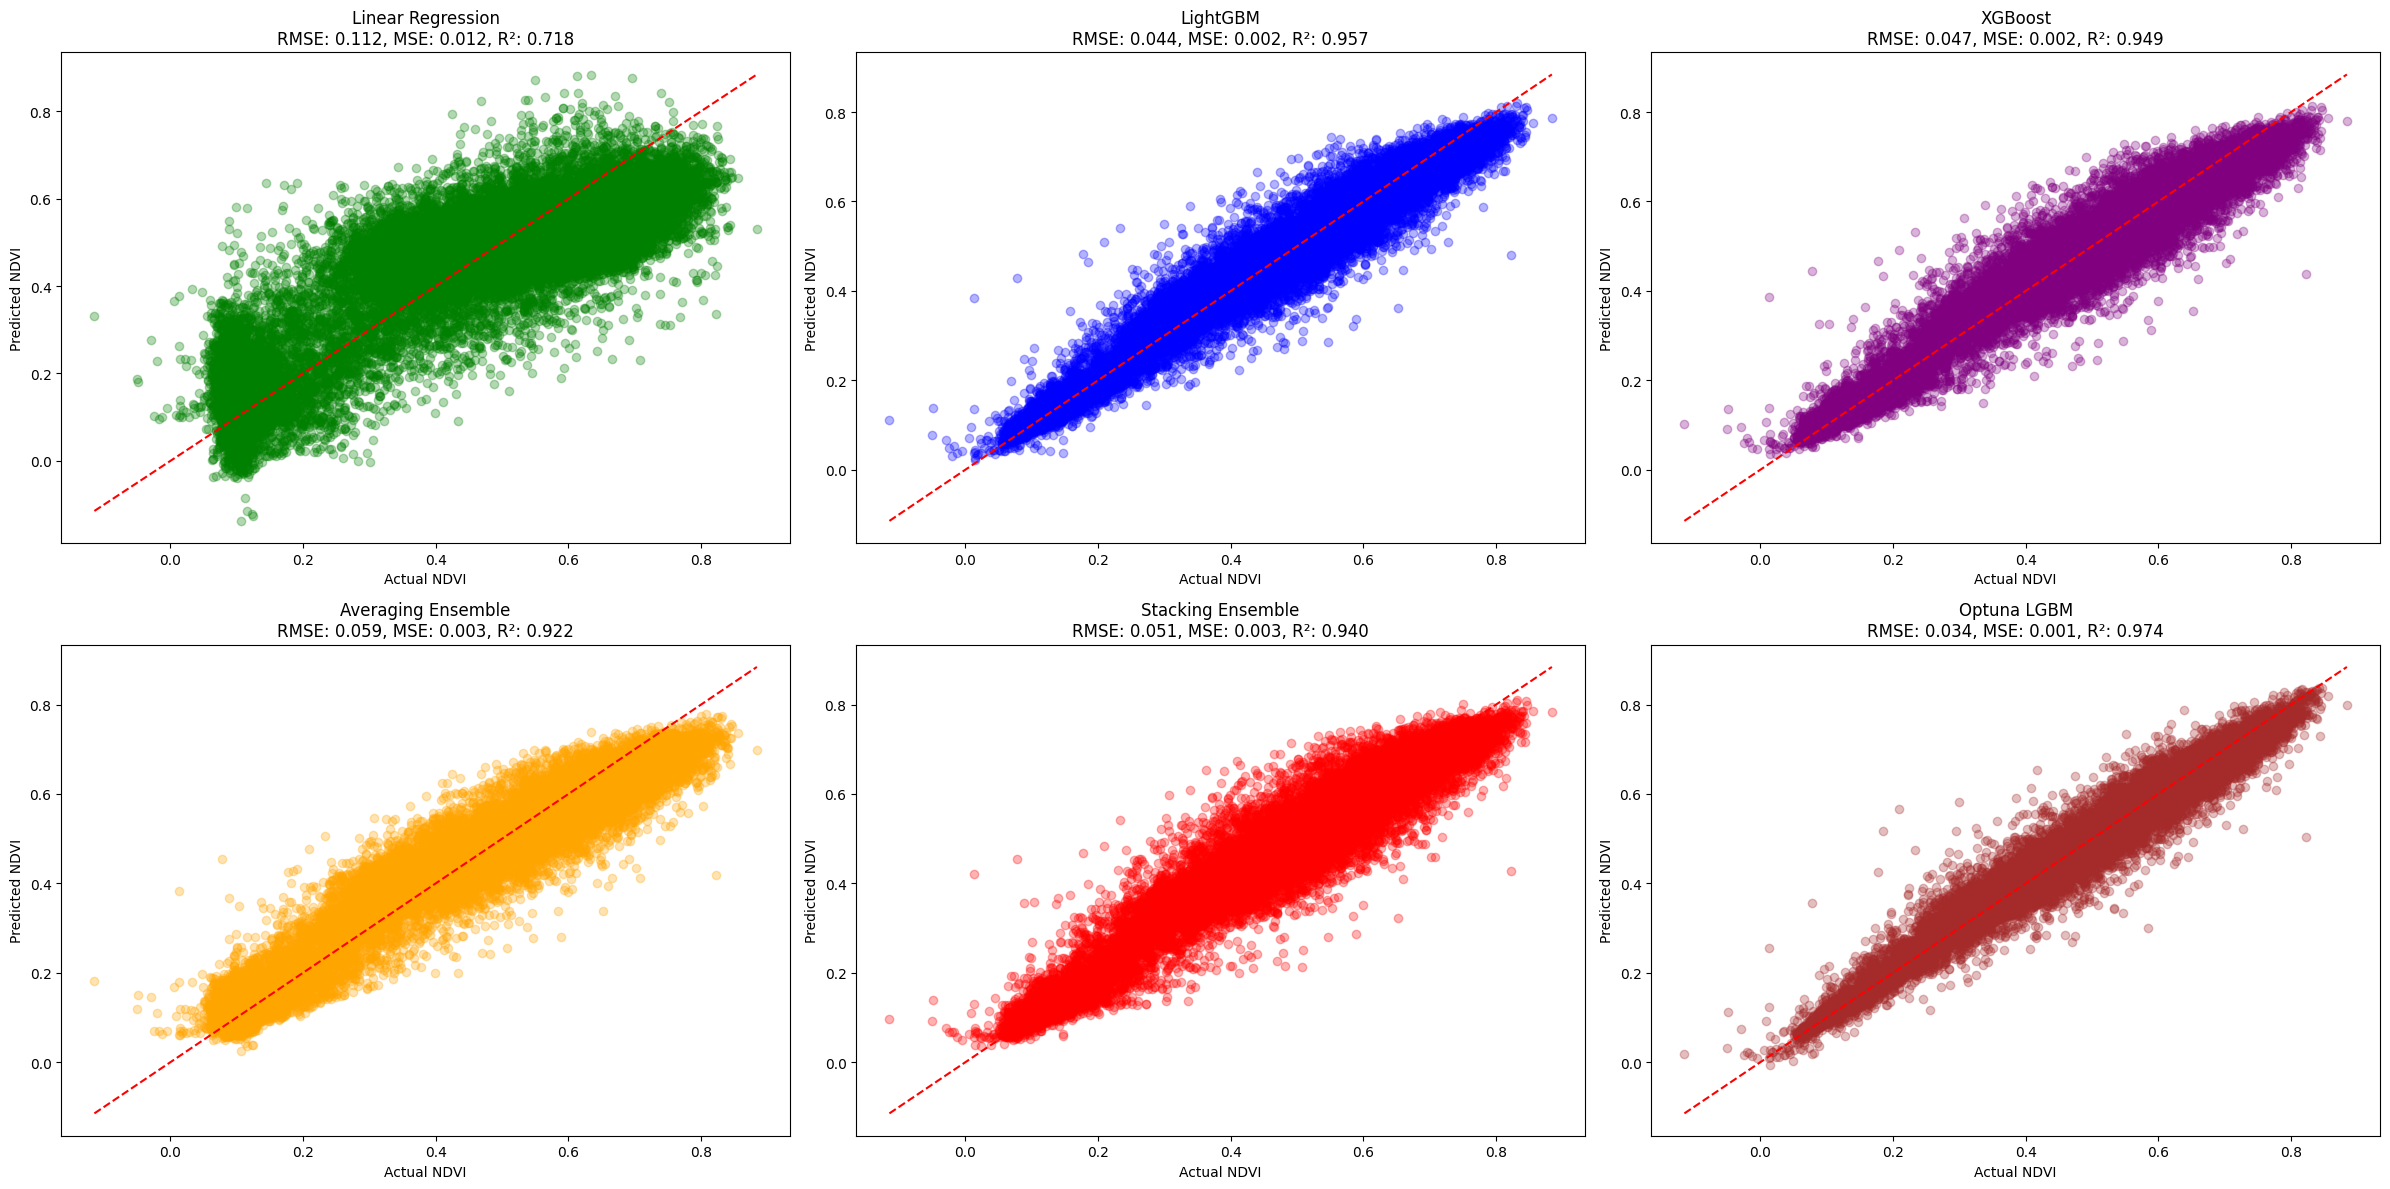

In [142]:
# Scatterplots for all models including Optuna
plt.figure(figsize=(24,12))

# Linear Regression
plt.subplot(2,3,1)
plt.scatter(y_test, y_pred_lr, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual NDVI")
plt.ylabel("Predicted NDVI")
plt.title(f"Linear Regression\nRMSE: {rmse_lr:.3f}, MSE: {mse_lr:.3f}, R²: {r2_lr:.3f}")

# LightGBM
plt.subplot(2,3,2)
plt.scatter(y_test, y_pred_lgb, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual NDVI")
plt.ylabel("Predicted NDVI")
plt.title(f"LightGBM\nRMSE: {rmse_lgb:.3f}, MSE: {mse_lgb:.3f}, R²: {r2_lgb:.3f}")

# XGBoost
plt.subplot(2,3,3)
plt.scatter(y_test, y_pred_xgb, alpha=0.3, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual NDVI")
plt.ylabel("Predicted NDVI")
plt.title(f"XGBoost\nRMSE: {rmse_xgb:.3f}, MSE: {mse_xgb:.3f}, R²: {r2_xgb:.3f}")

# Averaging Ensemble
plt.subplot(2,3,4)
plt.scatter(y_test, y_pred_avg, alpha=0.3, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual NDVI")
plt.ylabel("Predicted NDVI")
plt.title(f"Averaging Ensemble\nRMSE: {rmse_avg:.3f}, MSE: {mse_avg:.3f}, R²: {r2_avg:.3f}")

# Stacking Ensemble
plt.subplot(2,3,5)
plt.scatter(y_test, y_pred_stack, alpha=0.3, color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual NDVI")
plt.ylabel("Predicted NDVI")
plt.title(f"Stacking Ensemble\nRMSE: {rmse_stack:.3f}, MSE: {mse_stack:.3f}, R²: {r2_stack:.3f}")

# Optuna Tuned LightGBM
plt.subplot(2,3,6)
plt.scatter(y_valid, y_pred_optuna, alpha=0.3, color='brown')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.xlabel("Actual NDVI")
plt.ylabel("Predicted NDVI")
plt.title(f"Optuna LGBM\nRMSE: {rmse_optuna:.3f}, MSE: {mse_optuna:.3f}, R²: {r2_optuna:.3f}")

plt.tight_layout()
plt.show()

In [134]:
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

In [135]:
# Optimization history: RMSE per trial
fig1 = plot_optimization_history(study)
fig1.show()

In [136]:
# Parameter importance
fig2 = plot_param_importances(study)
fig2.show()

In [137]:
# Parallel coordinate
fig3 = plot_parallel_coordinate(study)
fig3.show()

In [138]:
# Slice plot
fig4 = plot_slice(study)
fig4.show()

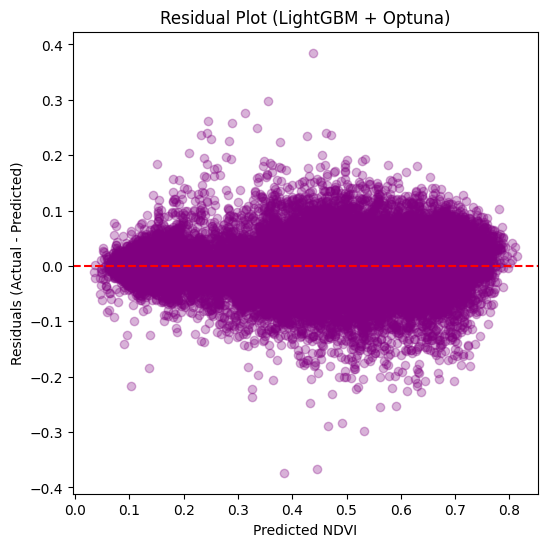

In [140]:
# Residuals
residuals = y_valid - y_pred

plt.figure(figsize=(6,6))
plt.scatter(y_pred, residuals, alpha=0.3, color="purple")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted NDVI")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot (LightGBM + Optuna)")
plt.show()

# **Save Best Model**

In [143]:
import joblib

In [144]:
joblib.dump(final_model, "final_lightgbm_optuna_model.pkl")

['final_lightgbm_optuna_model.pkl']